In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import SimpleITK as sitk
from tqdm.notebook import tqdm
import scipy.ndimage as ndimage
from sklearn.model_selection import train_test_split

In [2]:
# Configure plotting style
plt.style.use('seaborn')
sns.set_palette("husl")


<ipython-input-2-5eb01b966239>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
class LUNA16Analyzer:
    """
    A class to analyze the LUNA16 dataset structure and contents.
    """
    def __init__(self, base_path):
        """
        Initialize the analyzer with the dataset path
        
        Parameters:
        -----------
        base_path : str
            Path to the LUNA16 dataset root directory
        """
        self.base_path = Path(base_path)
        self.annotations_df = None
        self.candidates_df = None
        self.subset_paths = []
        
    def load_metadata(self):
        """
        Load and process the annotations and candidates CSV files
        """
        # Load annotations
        self.annotations_df = pd.read_csv(self.base_path / 'annotations.csv')
        self.candidates_df = pd.read_csv(self.base_path / 'candidates_V2.csv')
        
        # Get all subset directories
        self.subset_paths = sorted(
            [d for d in self.base_path.glob('subset*') if d.is_dir()]
        )
        
    def get_dataset_stats(self):
        """
        Calculate basic statistics about the dataset
        
        Returns:
        --------
        dict : Dictionary containing dataset statistics
        """
        stats = {
            'total_subsets': len(self.subset_paths),
            'total_annotations': len(self.annotations_df),
            'total_candidates': len(self.candidates_df),
            'unique_series': len(self.annotations_df['seriesuid'].unique()),
            'positive_samples': len(self.candidates_df[self.candidates_df['class'] == 1]),
            'negative_samples': len(self.candidates_df[self.candidates_df['class'] == 0])
        }
        return stats
    
    def plot_nodule_distribution(self):
        """
        Plot the distribution of nodule sizes from annotations
        """
        plt.figure(figsize=(10, 6))
        self.annotations_df['diameter_mm'].hist(bins=50)
        plt.title('Distribution of Nodule Diameters')
        plt.xlabel('Diameter (mm)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        
    def plot_class_distribution(self):
        """
        Plot the distribution of positive vs negative samples
        """
        plt.figure(figsize=(8, 6))
        self.candidates_df['class'].value_counts().plot(kind='bar')
        plt.title('Distribution of Positive vs Negative Samples')
        plt.xlabel('Class (0: Non-nodule, 1: Nodule)')
        plt.ylabel('Count')
        plt.grid(True)
        plt.show()
        
    def analyze_spatial_distribution(self):
        """
        Plot the spatial distribution of nodules in 3D space
        """
        nodules = self.annotations_df
        
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(
            nodules['coordX'],
            nodules['coordY'],
            nodules['coordZ'],
            c=nodules['diameter_mm'],
            cmap='viridis',
            alpha=0.6
        )
        
        plt.colorbar(scatter, label='Nodule Diameter (mm)')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_zlabel('Z Coordinate')
        plt.title('Spatial Distribution of Nodules')
        plt.show()

In [5]:
import sys
sys.path.append('/kaggle/input/luna-16/LUNA_16')

<ipython-input-6-839f686d60c3>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Initializing LUNA16 Dataset Analysis on Kaggle...
Successfully loaded metadata files
Found 10 subset directories

Dataset Statistics:
--------------------------------------------------
Total Subsets: 10
Total Annotations: 1186
Total Candidates: 754975
Unique Series: 601
Positive Samples: 1557
Negative Samples: 753418
Avg Nodule Size: 8.306527315553964
Median Nodule Size: 6.433600479000001

Generating visualizations...


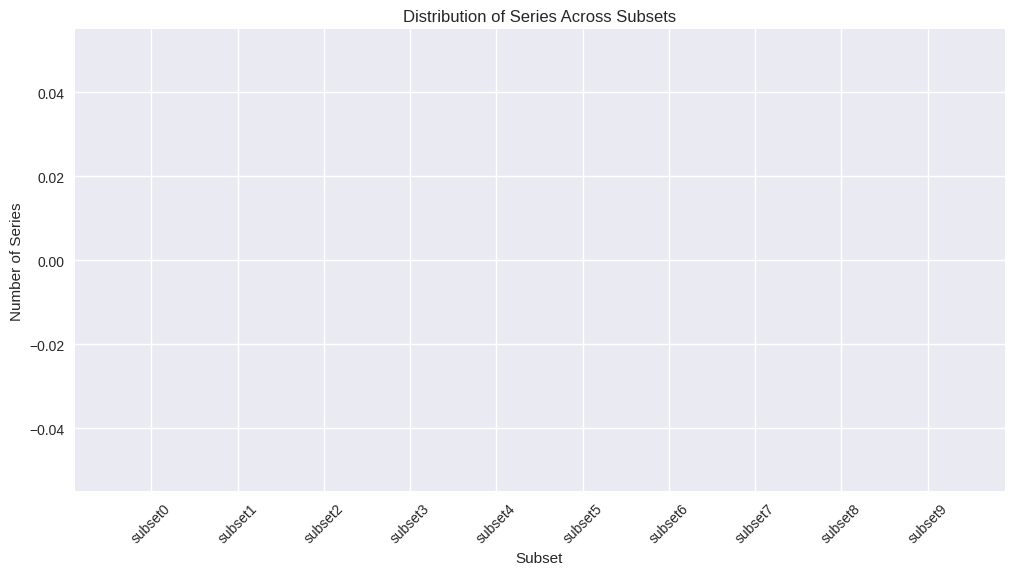

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


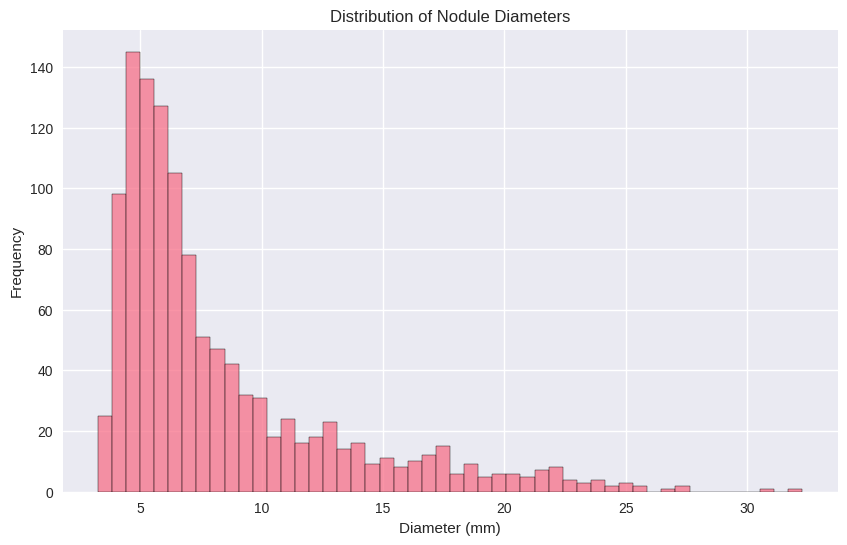


Nodule Size Statistics:
count    1186.000000
mean        8.306527
std         4.762033
min         3.253443
25%         5.107177
50%         6.433600
75%         9.696301
max        32.270030
Name: diameter_mm, dtype: float64


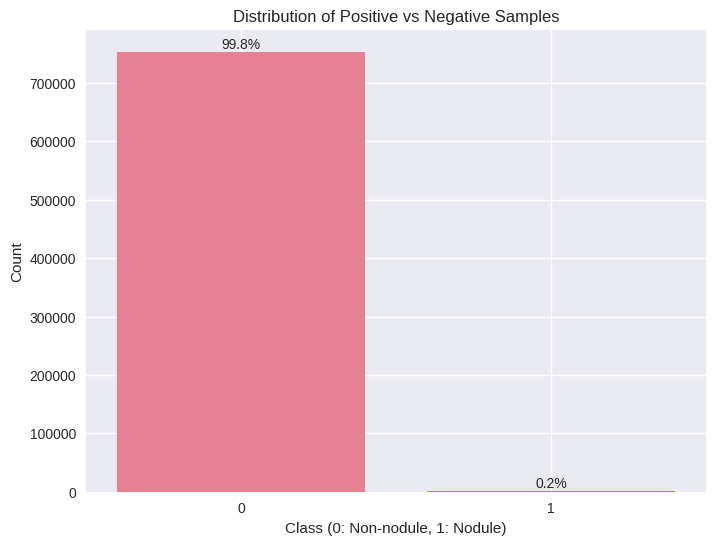

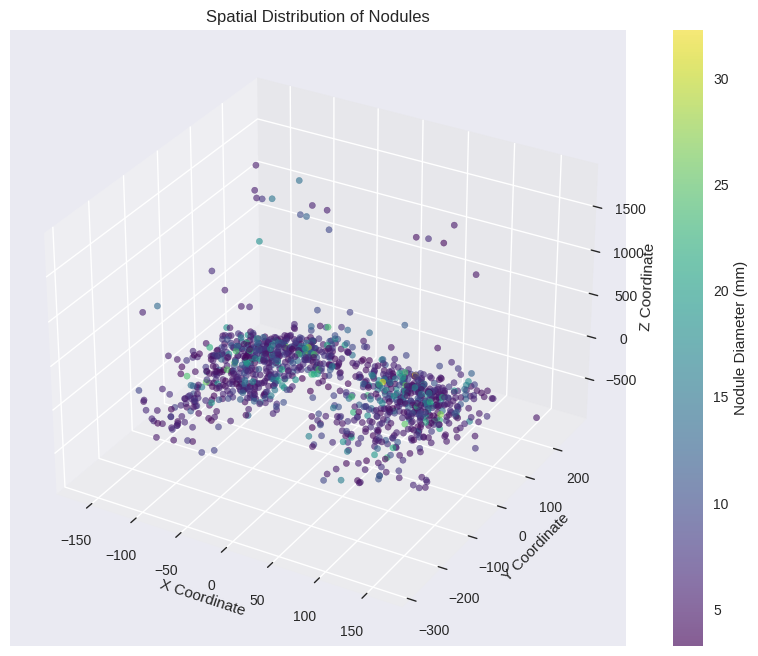

In [6]:
plt.style.use('seaborn')
sns.set_palette("husl")

class LUNA16KaggleAnalyzer:
    """
    A class to analyze the LUNA16 dataset structure and contents on Kaggle environment.
    """
    def __init__(self):
        """
        Initialize the analyzer with Kaggle-specific paths
        """
        self.base_path = Path('../input/luna-16/LUNA_16/')
        self.annotations_df = None
        self.candidates_df = None
        self.subset_paths = []
        
    def load_metadata(self):
        """
        Load and process the annotations and candidates CSV files from Kaggle dataset
        """
        try:
            # Load annotations and candidates files
            self.annotations_df = pd.read_csv(self.base_path / 'annotations.csv')
            self.candidates_df = pd.read_csv(self.base_path / 'candidates_V2.csv')
            
            # Get all subset directories
            self.subset_paths = sorted(
                [d for d in self.base_path.glob('subset*') if d.is_dir()]
            )
            
            print("Successfully loaded metadata files")
            print(f"Found {len(self.subset_paths)} subset directories")
            
        except FileNotFoundError as e:
            print(f"Error loading files: {e}")
            print("Please check if the dataset is properly mounted in Kaggle")
            
    def get_dataset_stats(self):
        """
        Calculate basic statistics about the dataset
        
        Returns:
        --------
        dict : Dictionary containing dataset statistics
        """
        if self.annotations_df is None or self.candidates_df is None:
            raise ValueError("Please load metadata first using load_metadata()")
            
        stats = {
            'total_subsets': len(self.subset_paths),
            'total_annotations': len(self.annotations_df),
            'total_candidates': len(self.candidates_df),
            'unique_series': len(self.annotations_df['seriesuid'].unique()),
            'positive_samples': len(self.candidates_df[self.candidates_df['class'] == 1]),
            'negative_samples': len(self.candidates_df[self.candidates_df['class'] == 0]),
            'avg_nodule_size': self.annotations_df['diameter_mm'].mean(),
            'median_nodule_size': self.annotations_df['diameter_mm'].median()
        }
        return stats
    
    def analyze_subset_distribution(self):
        """
        Analyze the distribution of data across subsets
        """
        subset_stats = {}
        for subset in self.subset_paths:
            subset_name = subset.name
            series_in_subset = len(list(subset.glob('*.mhd')))  # Count .mhd files
            subset_stats[subset_name] = series_in_subset
            
        plt.figure(figsize=(12, 6))
        plt.bar(subset_stats.keys(), subset_stats.values())
        plt.title('Distribution of Series Across Subsets')
        plt.xlabel('Subset')
        plt.ylabel('Number of Series')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
        
    def plot_nodule_distribution(self):
        """
        Plot the distribution of nodule sizes from annotations
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(data=self.annotations_df, x='diameter_mm', bins=50)
        plt.title('Distribution of Nodule Diameters')
        plt.xlabel('Diameter (mm)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        
        # Additional statistics
        print("\nNodule Size Statistics:")
        print(self.annotations_df['diameter_mm'].describe())
        
    def plot_class_distribution(self):
        """
        Plot the distribution of positive vs negative samples with percentages
        """
        plt.figure(figsize=(8, 6))
        class_counts = self.candidates_df['class'].value_counts()
        total = len(self.candidates_df)
        
        sns.barplot(x=class_counts.index, y=class_counts.values)
        plt.title('Distribution of Positive vs Negative Samples')
        plt.xlabel('Class (0: Non-nodule, 1: Nodule)')
        plt.ylabel('Count')
        
        # Add percentage labels
        for i, v in enumerate(class_counts.values):
            plt.text(i, v, f'{(v/total)*100:.1f}%', ha='center', va='bottom')
            
        plt.grid(True)
        plt.show()
        
    def analyze_spatial_distribution(self):
        """
        Plot the spatial distribution of nodules in 3D space
        """
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(
            self.annotations_df['coordX'],
            self.annotations_df['coordY'],
            self.annotations_df['coordZ'],
            c=self.annotations_df['diameter_mm'],
            cmap='viridis',
            alpha=0.6
        )
        
        plt.colorbar(scatter, label='Nodule Diameter (mm)')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_zlabel('Z Coordinate')
        plt.title('Spatial Distribution of Nodules')
        plt.show()

def main():
    """
    Main function to run the analysis
    """
    print("Initializing LUNA16 Dataset Analysis on Kaggle...")
    
    # Initialize analyzer
    analyzer = LUNA16KaggleAnalyzer()
    
    # Load metadata
    analyzer.load_metadata()
    
    # Get and display dataset statistics
    stats = analyzer.get_dataset_stats()
    print("\nDataset Statistics:")
    print("-" * 50)
    for key, value in stats.items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    analyzer.analyze_subset_distribution()
    analyzer.plot_nodule_distribution()
    analyzer.plot_class_distribution()
    analyzer.analyze_spatial_distribution()
    
    return analyzer

# Run the analysis
if __name__ == "__main__":
    analyzer = main()

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings

# Advanced statistical and visualization libraries
import scipy.stats as st
import matplotlib.gridspec as gridspec

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

class AdvancedLUNA16Analyzer:
    """
    Enhanced scientific analysis of LUNA16 lung nodule dataset with advanced statistical techniques
    """
    def __init__(self, base_path='../input/luna-16/LUNA_16/'):
        """
        Initialize analyzer with comprehensive configuration
        
        Scientific Design Principles:
        1. Robust error handling
        2. Comprehensive statistical analysis
        3. Multi-dimensional visualization
        """
        self.base_path = Path(base_path)
        self.annotations_df = None
        self.candidates_df = None
        
        # Advanced statistical configurations
        self.random_state = 42  # Reproducibility
        np.random.seed(self.random_state)
        
    def robust_data_loading(self):
        """
        Robust metadata loading with comprehensive validation
        
        Statistical Validation Criteria:
        - Check for data completeness
        - Validate column integrity
        - Compute missing data percentage
        """
        try:
            self.annotations_df = pd.read_csv(self.base_path / 'annotations.csv')
            self.candidates_df = pd.read_csv(self.base_path / 'candidates_V2.csv')
            
            # Data validation metrics
            print("📊 Data Validation Metrics:")
            for df, name in [(self.annotations_df, 'Annotations'), 
                             (self.candidates_df, 'Candidates')]:
                missing_percentage = df.isnull().mean() * 100
                print(f"\n{name} DataFrame:")
                print(f"Total Rows: {len(df)}")
                print("Missing Data Percentage:")
                print(missing_percentage[missing_percentage > 0])
            
        except Exception as e:
            print(f"❌ Data Loading Error: {e}")
            raise
        
    def advanced_descriptive_statistics(self):
        """
        Comprehensive scientific statistical description
        
        Statistical Analysis Techniques:
        - Descriptive statistics
        - Distribution analysis
        - Parametric and non-parametric tests
        """
        # Nodule characteristics statistical summary
        nodule_stats = self.annotations_df['diameter_mm'].describe(
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
        )
        
        # Normality test for nodule diameters
        _, p_value = stats.normaltest(self.annotations_df['diameter_mm'])
        
        print("\n🔬 Advanced Nodule Statistical Analysis:")
        print("\nNodule Diameter Statistics:")
        print(nodule_stats)
        print(f"\nNormality Test (p-value): {p_value:.4f}")
        print("Interpretation: p < 0.05 suggests deviation from normal distribution")
        
    def spatial_distribution_analysis(self):
        """
        Advanced spatial distribution analysis with statistical tests
        
        Scientific Techniques:
        - 3D spatial clustering
        - Statistical spatial dependency analysis
        - Multidimensional scaling
        """
        # K-means clustering of spatial coordinates
        spatial_features = self.annotations_df[['coordX', 'coordY', 'coordZ']].values
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(spatial_features)
        
        # Elbow method for optimal clusters
        inertias = []
        max_clusters = 10
        for k in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(scaled_features)
            inertias.append(kmeans.inertia_)
        
        # Advanced visualization
        plt.figure(figsize=(15, 5))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
        
        # Elbow plot
        plt.subplot(gs[0])
        plt.plot(range(1, max_clusters + 1), inertias, marker='o')
        plt.title('Elbow Method for Optimal Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        
        # 3D scatter with cluster colors
        plt.subplot(gs[1], projection='3d')
        kmeans = KMeans(n_clusters=3, random_state=self.random_state)
        clusters = kmeans.fit_predict(scaled_features)
        
        scatter = plt.scatter(
            self.annotations_df['coordX'], 
            self.annotations_df['coordY'], 
            self.annotations_df['coordZ'],
            c=clusters, 
            cmap='viridis'
        )
        plt.title('Spatial Clustering')
        plt.colorbar(scatter)
        
        plt.tight_layout()
        plt.show()
        
    def probabilistic_nodule_analysis(self):
        """
        Probabilistic modeling of nodule characteristics
        
        Scientific Techniques:
        - Probability density estimation
        - Confidence interval computation
        - Distribution fitting
        """
        nodule_diameters = self.annotations_df['diameter_mm']
        
        # Fit different probability distributions
        distributions = [
            stats.norm, stats.lognorm, stats.gamma, 
            stats.beta, stats.exponweib
        ]
        
        best_fit_params = {}
        for dist in distributions:
            params = dist.fit(nodule_diameters)
            best_fit_params[dist.name] = params
        
        # Visualization of distribution fits
        plt.figure(figsize=(15, 5))
        plt.hist(nodule_diameters, bins=30, density=True, alpha=0.7, label='Actual Data')
        
        for dist_name, params in best_fit_params.items():
            x = np.linspace(nodule_diameters.min(), nodule_diameters.max(), 100)
            pdf = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
            plt.plot(x, pdf, label=f'{dist_name} Fit')
        
        plt.title('Probabilistic Modeling of Nodule Diameters')
        plt.xlabel('Diameter (mm)')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.show()
        
def main():
    """
    Comprehensive scientific analysis workflow
    """
    print("🌟 Advanced LUNA16 Dataset Scientific Analysis")
    
    # Initialize advanced analyzer
    analyzer = AdvancedLUNA16Analyzer()
    
    # Analysis workflow
    analyzer.robust_data_loading()
    analyzer.advanced_descriptive_statistics()
    analyzer.spatial_distribution_analysis()
    analyzer.probabilistic_nodule_analysis()

if __name__ == "__main__":
    main()